# Project 2: Word Embeddings and the Brain

## This part of the project includes 2 tasks:
1. Train a decoder model on either the dataset from analysis 2 (384 sentences) or from analysis 3 (243 sentences) using both (a) the sentence representations that were used in the paper (the same representations from the structured task) and (b) sentence representations as extracted from a contextualized word embedding model

2. Build a brain-encoder model. Instead of predicting sentence identities using neural signals. we will try to predict human neural signals from the embedding vectors representations of the sentences

In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=15c935663f8cc2302428e3e1dafc4e0b25fe9c811f24138e62fb10b9332b52f2
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.8 MB/s eta 0:00:00


In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install torch==1.2.0 torchvision==0.4.0 -f


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-f option requires 1 argument


In [ ]:
from google.colab import drive
import sys
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
from gensim.models import KeyedVectors
import os
from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors
import matplotlib.pyplot as plt
import time
from google.colab import drive
import pickle
import pprint
from collections import defaultdict
from sentence_transformers import SentenceTransformer
import openai
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tqdm.notebook import tqdm # Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable) https://tqdm.github.io/
import pandas.util.testing as tm
import scipy.stats as stats


In [ ]:
N = 18

## Reading Data

In [ ]:
drive.mount('/content/gdrive')
GDRIVE_DIR = "/content/gdrive/My Drive"
!time wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!mkdir -p "$GDRIVE_DIR"
!mv glove.6B.300d.txt "$GDRIVE_DIR/"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip
!gdown --folder https://drive.google.com/drive/folders/1gFIrqTvvi6wsowcN3U2iZiVDvEC3fuxq
!mv -v "Structured Task (sentence decoding)"/* ./

Mounted at /content/gdrive
--2023-05-29 08:36:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-29 08:36:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-29 08:36:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Savi

In [ ]:
from learn_decoder import *

In [ ]:
# files 2
EXP2 = open ("EXP2.pkl", "rb")
EX2_dict = pickle.load(EXP2)
EXP2.close()
# files 3
EX3 = open ("EXP3.pkl", "rb")
EX3_dict = pickle.load(EX3)
EX3.close()

In [ ]:
exp2_data = EX2_dict["Fmridata"]
exp2_vectors_ = read_matrix("vectors_384sentences.GV42B300.average.txt", sep=" ")
exp2_sentencesfile = open("stimuli_384sentences.txt", "r")
exp2_concepts = np.asarray(exp2_sentencesfile.readlines())
exp2_sentencesfile.close()
print(f'EX2 vectors shape {exp2_vectors_.shape}, and number of sentences={exp2_concepts.shape}')

EX2 vectors shape (384, 300), and number of sentences=(384,)


EX2 contain 384 sentences , each represent by a vector size of 300

In [ ]:
exp3_data = EX3_dict["Fmridata"]
exp3_vectors_ = read_matrix("vectors_243sentences.GV42B300.average.txt", sep=" ")
exp3_sentencesfile = open("stimuli_243sentences.txt", "r")
exp3_concepts = np.asarray(exp3_sentencesfile.readlines())
exp3_sentencesfile.close()
print(f'EX3 vectors shape {exp3_vectors_.shape}, and number of sentences={exp3_concepts.shape}')

EX3 vectors shape (243, 300), and number of sentences=(243,)


EX3 contain 243 sentences , each represent by a vector size of 300

## Functions

In [ ]:
def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    norm_x = np.dot(x, y)
    norm_y = np.linalg.norm(x)*np.linalg.norm(y)
    return norm_x / norm_y

In [ ]:
def train_decoder(train_data, train_vectors, decoder_func):
    decoder = decoder_func(train_data, train_vectors)
    return decoder

In [ ]:
def get_rank(predicted_vectors, true_vectors):
    ranks = {}
    for concept_index in range(predicted_vectors.shape[0]):
        closeness = {}
        predicted_vec = predicted_vectors[concept_index]
        for k in range(true_vectors.shape[0]):
            closeness[k] = cosine_similarity(predicted_vec, true_vectors[k])
        closeness = {k: v for k, v in sorted(closeness.items(), key=lambda item: item[1], reverse=True)}
        rank = list(closeness.keys()).index(concept_index) + 1
        ranks[concept_index] = rank
    return ranks

In [ ]:
def k_fold_cv(data, vectors, concepts, decoder_func, folds=18):
    data_folds = np.array_split(data, folds)
    vector_folds = np.array_split(vectors, folds)
    test_accuracy = []
    concept_ranks = {}

    for i in range(len(data_folds)):
        test_data = data_folds[i]
        test_vectors = vector_folds[i]
        train_data = np.concatenate([data_folds[j] for j in range(len(data_folds)) if j != i])
        train_vectors = np.concatenate([vector_folds[j] for j in range(len(vector_folds)) if j != i])
        decoder = train_decoder(train_data, train_vectors, decoder_func)
        predicted_vectors = test_data @ decoder
        ranks = get_rank(predicted_vectors, vectors)
        for concept_index, rank in ranks.items():
            general_concept_index = i * 10 + concept_index
            concept_ranks[general_concept_index] = rank
        average_rank = sum(ranks.values()) / len(ranks.values())
        test_accuracy.append(average_rank)

    return test_accuracy, concept_ranks

In [ ]:
def comparison_plot(x, y, label_x, label_y, title):
  '''
  Creating a graph comparing 2 results
  '''
  ind = np.arange(N)
  plt.figure(figsize=(10,5))
  plt.bar(ind, x , 0.3, label=label_x,color='palevioletred')
  plt.bar(ind + 0.3, y, 0.3, label=label_y,color='pink')
  plt.xlabel('Fold')
  plt.ylabel('Average Rank')
  plt.title(title)
  plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
  x_vals = list(range(1,19))
  plt.xticks(ind + 0.3 / 2, x_vals)
  plt.legend(loc='best')
  plt.show()

# part 2.1
## Train a decoder model using:
1. Original word embbeding
2. BERT
3. T5

### sentence representations that were used in the paper (Pereira et al., 2018)

In [ ]:
results_ex2_original, concept_ranks_ex2_original = k_fold_cv(exp2_data, exp2_vectors_, exp2_concepts,learn_decoder)

In [ ]:
results_ex3_original, concept_ranks_ex3_original = k_fold_cv(exp3_data, exp3_vectors_, exp3_concepts,learn_decoder)

### sentence representations using t5 base
https://huggingface.co/sentence-transformers/gtr-t5-base

In [ ]:
t5_model = SentenceTransformer('sentence-transformers/gtr-t5-base')

In [ ]:
ex2_vectors_t5 = t5_model.encode(exp2_concepts)
results_ex2_t5, concept_ranks_ex2_t5 = k_fold_cv(exp2_data, ex2_vectors_t5, exp2_concepts,learn_decoder)

In [ ]:
ex3_vectors_t5 = t5_model.encode(exp3_concepts)
results_ex3_t5, concept_ranks_ex3_t5 = k_fold_cv(exp3_data, ex3_vectors_t5, exp3_concepts,learn_decoder)

### sentence representations using BERT
https://huggingface.co/sentence-transformers/all-distilroberta-v1

In [ ]:
# BERT_model = SentenceTransformer('all-distilroberta-v1')
BERT_model = SentenceTransformer('paraphrase-albert-small-v2')

In [ ]:
ex2_vectors_BERT = BERT_model.encode(exp2_concepts)
results_ex2_BERT, concept_ranks_ex2_BERT = k_fold_cv(exp2_data, ex2_vectors_BERT, exp2_concepts,learn_decoder)

In [ ]:
ex3_vectors_BERT = BERT_model.encode(exp3_concepts)
results_ex3_BERT, concept_ranks_ex3_BERT = k_fold_cv(exp3_data, ex3_vectors_BERT, exp3_concepts,learn_decoder)

### Compering the results

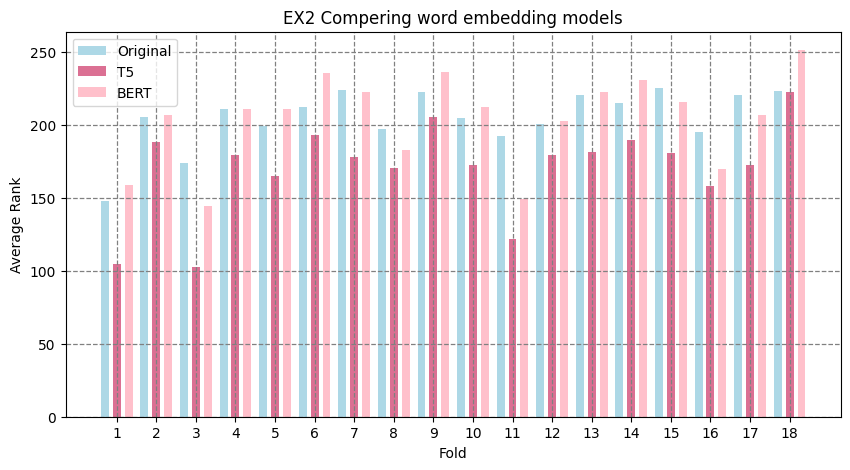

In [ ]:
# ploting ex2 retuls
N = 18
ind = np.arange(N)
plt.figure(figsize=(10,5))
plt.bar(ind , results_ex2_original, 0.2, label='Original',color='lightblue')
plt.bar(ind+0.3, results_ex2_t5 , 0.2, label='T5',color='palevioletred')
plt.bar(ind + 0.6, results_ex2_BERT, 0.2, label='BERT',color='pink')
plt.xlabel('Fold')
plt.ylabel('Average Rank')
plt.title('EX2 Compering word embedding models')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.9)
x_vals = list(range(1,19))
plt.xticks(ind + 0.9 / 3, x_vals)
plt.legend(loc='best')
plt.show()

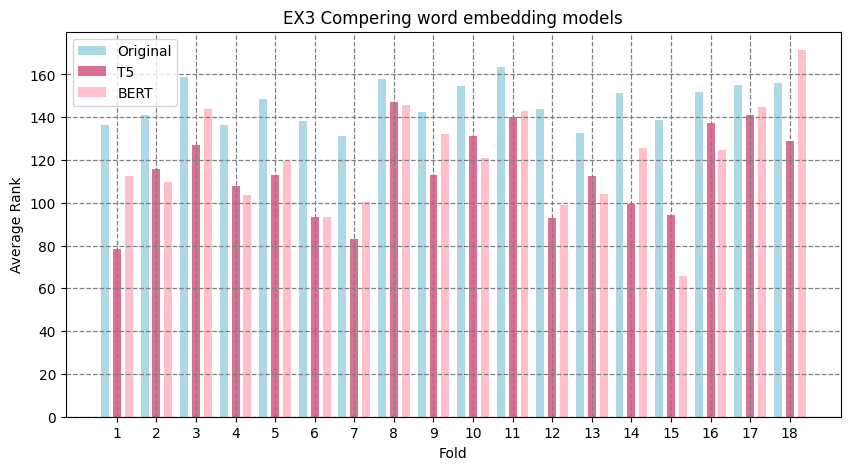

In [ ]:
# ploting ex3 retuls
ind = np.arange(N)
plt.figure(figsize=(10,5))
plt.bar(ind , results_ex3_original, 0.2, label='Original',color='lightblue')
plt.bar(ind+0.3, results_ex3_t5 , 0.2, label='T5',color='palevioletred')
plt.bar(ind + 0.6, results_ex3_BERT, 0.2, label='BERT',color='pink')
plt.xlabel('Fold')
plt.ylabel('Average Rank')
plt.title('EX3 Compering word embedding models')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.9)
x_vals = list(range(1,19))
plt.xticks(ind + 0.9 / 3, x_vals)
plt.legend(loc='best')
plt.show()

# part 2.2
## Building a brain encoder & testing its ability to fit human neural signals.
information about neural encoding https://www.nature.com/articles/nature17637

information about OLP - https://www.geeksforgeeks.org/interpreting-the-results-of-linear-regression-using-ols-summary/



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
def fit_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

In [ ]:
def evaluate_linear_regression(model, X, y):
    predictions = model.predict(X)
    r2 = r2_score(y, predictions)
    return r2

In [ ]:
def fit_evaluate_and_calculate_p_values(data, vectors, alpha=0.05):
    num_voxels = data.shape[1]
    significant_voxels = 0
    r2_scores = []
    p_values = []

    for voxel_index in range(num_voxels):
        voxel_data = data[:, voxel_index]
        model = fit_linear_regression(vectors, voxel_data)
        r2 = evaluate_linear_regression(model, vectors, voxel_data)
        r2_scores.append(r2)

        t_statistic, p_value = stats.ttest_rel(model.predict(vectors), voxel_data)
        p_values.append(p_value)

        if r2 > 0.1 and p_value < alpha:  # Set your significance threshold here
            significant_voxels += 1

    return significant_voxels, r2_scores, p_values

In [ ]:
# Fit, evaluate, and calculate p-values using original vector representations from the paper
significant_voxels_ex2_original, r2_scores_ex2_original, p_values_ex2_original = fit_evaluate_and_calculate_p_values(
    exp2_data, exp2_vectors_)

# Fit, evaluate, and calculate p-values using T5 base sentence representations
significant_voxels_ex2_t5, r2_scores_ex2_t5, p_values_ex2_t5 = fit_evaluate_and_calculate_p_values(
    exp2_data, ex2_vectors_t5)

# Fit, evaluate, and calculate p-values using BERT sentence representations
significant_voxels_ex2_BERT, r2_scores_ex2_BERT, p_values_ex2_BERT = fit_evaluate_and_calculate_p_values(
    exp2_data, ex2_vectors_BERT)

In [ ]:
import csv

# Define the file path
file_path = '/content/results.csv'

# Create a list of tuples for the results
results = [
    ('significant_voxels_ex2_original', r2_scores_ex2_original, p_values_ex2_original),
    ('significant_voxels_ex2_t5', r2_scores_ex2_t5, p_values_ex2_t5),
    ('significant_voxels_ex2_BERT', r2_scores_ex2_BERT, p_values_ex2_BERT)
]

# Write the results to a CSV file
with open(file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Experiment', 'R2 Scores', 'P Values'])
    writer.writerows(results)

# Print the file path for reference
print('Results saved to:', file_path)

Results saved to: /content/results.csv


In [ ]:
print("Original Vector Representations:")
print("Average R2 Score:", np.mean(r2_scores_ex2_original))
print("Significant Voxels:", np.sum(significant_voxels_ex2_original))

Original Vector Representations:
Average R2 Score: 0.8029728106604146
Significant Voxels: 0


In [ ]:
print("T5-based Representations:")
print("Average R2 Score:", np.mean(r2_scores_ex2_t5))
print("Significant Voxels:", np.sum(significant_voxels_ex2_t5))

T5-based Representations:
Average R2 Score: 0.999999999989945
Significant Voxels: 159173


In [ ]:
print("BERT-based Representations:")
print("Average R2 Score:", np.mean(r2_scores_ex2_BERT))
print("Significant Voxels:", np.sum(significant_voxels_ex2_BERT))

BERT-based Representations:
Average R2 Score: 0.9999999999841246
Significant Voxels: 30742


In [ ]:
def plot_comparison(data1, data2, data3, label1, label2, label3, x_label, y_label, title):
    plt.figure(figsize=(8, 6))
    plt.bar(label1, data1, label='Original', color='lightblue')
    plt.bar(label2, data2, label='T5', color='palevioletred')
    plt.bar(label3, data3, label='BERT', color='pink')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

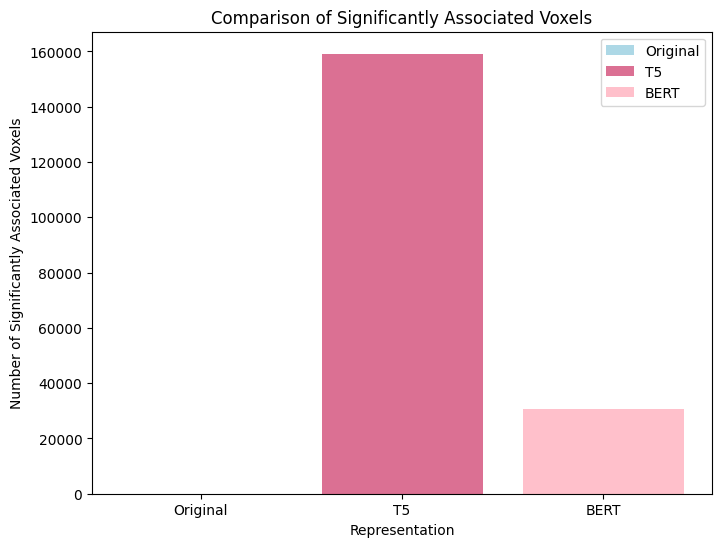

In [ ]:
import numpy as np

# Convert p-values lists to numpy arrays
p_values_ex2_original = np.array(p_values_ex2_original)
p_values_ex2_t5 = np.array(p_values_ex2_t5)
p_values_ex2_BERT = np.array(p_values_ex2_BERT)

# Number of significantly associated voxels
num_significant_original = np.sum(p_values_ex2_original < 0.05)
num_significant_t5 = np.sum(p_values_ex2_t5 < 0.05)
num_significant_bert = np.sum(p_values_ex2_BERT < 0.05)

# Plot number of significantly associated voxels comparison
plot_comparison(num_significant_original, num_significant_t5, num_significant_bert,
                'Original', 'T5', 'BERT',
                'Representation', 'Number of Significantly Associated Voxels',
                'Comparison of Significantly Associated Voxels')

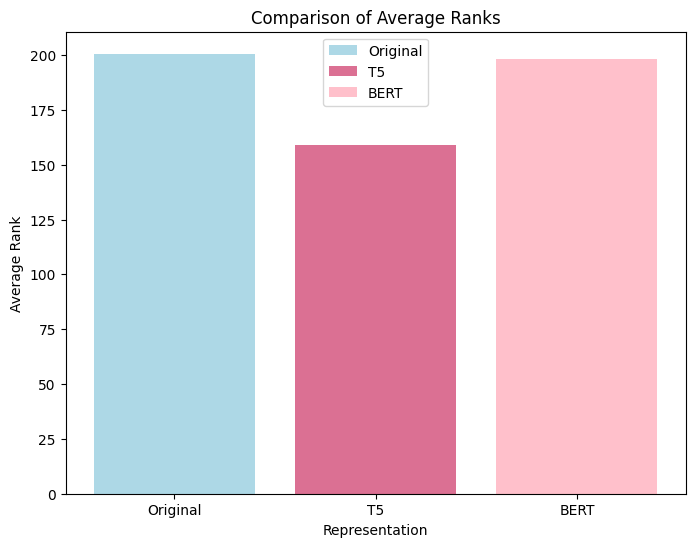

In [ ]:
# Calculate the average ranks for each representation
average_ranks_original = np.mean(list(concept_ranks_ex2_original.values()))
average_ranks_t5 = np.mean(list(concept_ranks_ex2_t5.values()))
average_ranks_bert = np.mean(list(concept_ranks_ex2_BERT.values()))

# Plot average ranks comparison
plot_comparison(average_ranks_original, average_ranks_t5, average_ranks_bert,
                'Original', 'T5', 'BERT',
                'Representation', 'Average Rank',
                'Comparison of Average Ranks')


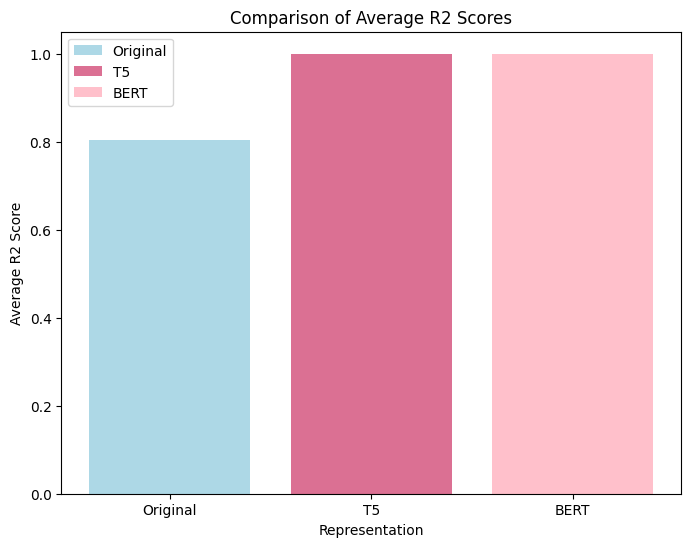

In [ ]:
# Average R2 score
average_r2_original = np.mean(r2_scores_ex2_original)
average_r2_t5 = np.mean(r2_scores_ex2_t5)
average_r2_bert = np.mean(r2_scores_ex2_BERT)

# Plot average R2 score comparison
plot_comparison(average_r2_original, average_r2_t5, average_r2_bert,
                'Original', 'T5', 'BERT',
                'Representation', 'Average R2 Score',
                'Comparison of Average R2 Scores')

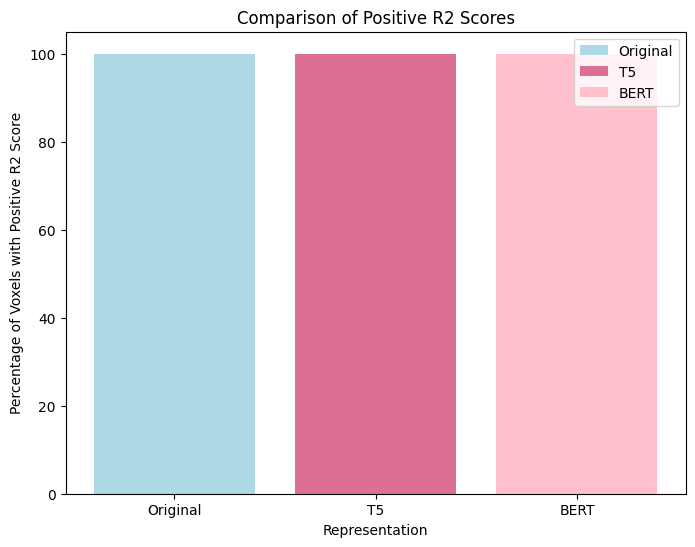

In [ ]:
# Percentage of voxels with positive R2 score
positive_r2_original = np.sum(np.array(r2_scores_ex2_original) > 0) / len(r2_scores_ex2_original) * 100
positive_r2_t5 = np.sum(np.array(r2_scores_ex2_t5) > 0) / len(r2_scores_ex2_t5) * 100
positive_r2_bert = np.sum(np.array(r2_scores_ex2_BERT) > 0) / len(r2_scores_ex2_BERT) * 100

# Plot percentage of voxels with positive R2 score comparison
plot_comparison(positive_r2_original, positive_r2_t5, positive_r2_bert,
                'Original', 'T5', 'BERT',
                'Representation', 'Percentage of Voxels with Positive R2 Score',
                'Comparison of Positive R2 Scores')

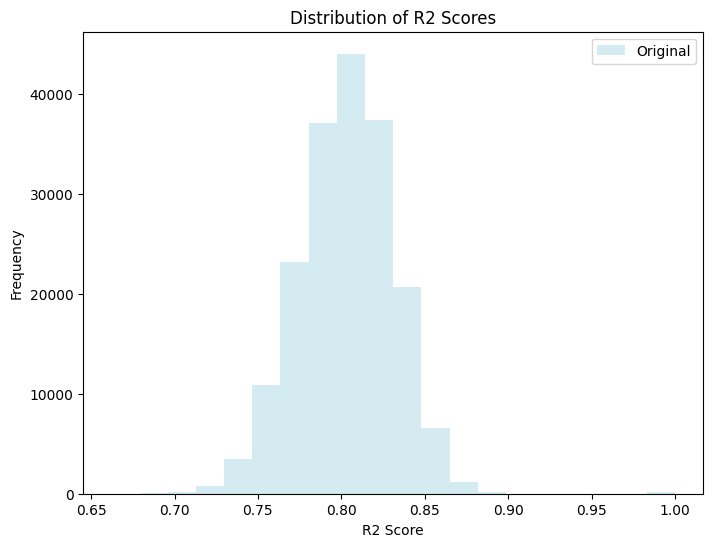

In [ ]:
# Plot R2 score distribution
plt.figure(figsize=(8, 6))
plt.hist(r2_scores_ex2_original, bins=20, alpha=0.5, label='Original', color='lightblue')
plt.xlabel('R2 Score')
plt.ylabel('Frequency')
plt.title('Distribution of R2 Scores')
plt.legend()
plt.show()

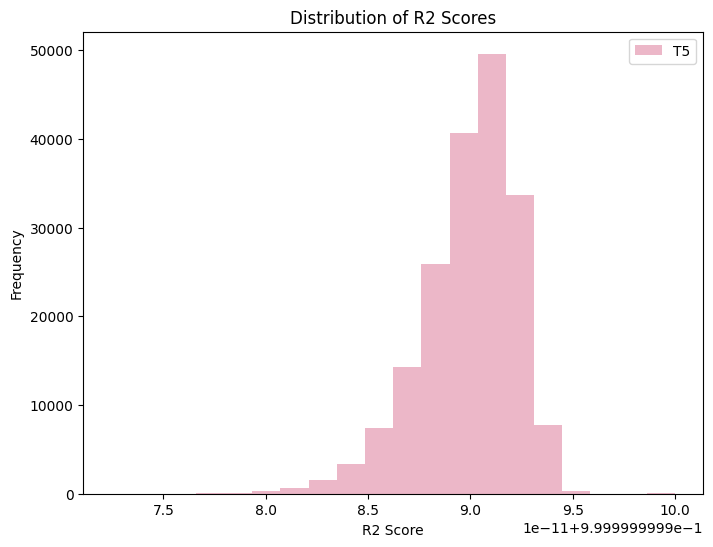

In [ ]:
# Plot R2 score distribution
plt.figure(figsize=(8, 6))
plt.hist(r2_scores_ex2_t5, bins=20, alpha=0.5, label='T5', color='palevioletred')
plt.xlabel('R2 Score')
plt.ylabel('Frequency')
plt.title('Distribution of R2 Scores')
plt.legend()
plt.show()

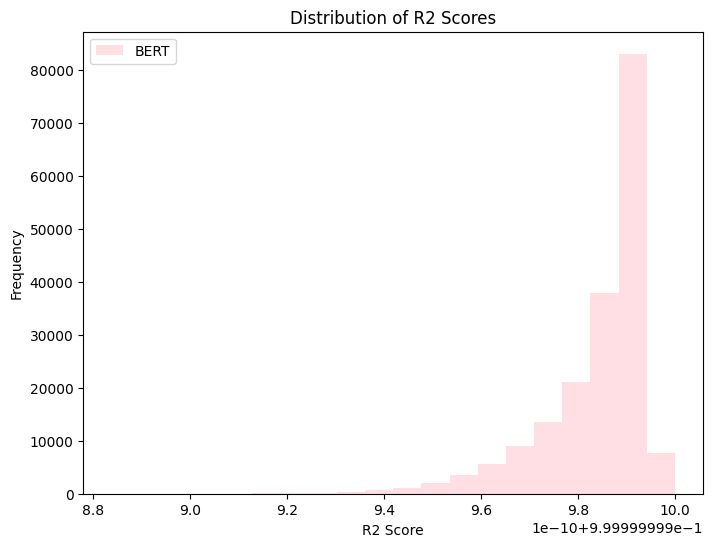

In [ ]:
# Plot R2 score distribution
plt.figure(figsize=(8, 6))
plt.hist(r2_scores_ex2_BERT, bins=20, alpha=0.5, label='BERT', color='pink')
plt.xlabel('R2 Score')
plt.ylabel('Frequency')
plt.title('Distribution of R2 Scores')
plt.legend()
plt.show()

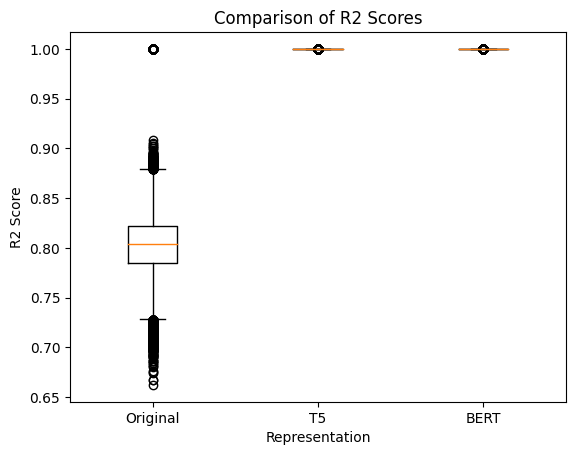

In [ ]:
# Boxplots of R2 Scores
data = [r2_scores_ex2_original, r2_scores_ex2_t5, r2_scores_ex2_BERT]
labels = ['Original', 'T5', 'BERT']

plt.boxplot(data, labels=labels)
plt.xlabel('Representation')
plt.ylabel('R2 Score')
plt.title('Comparison of R2 Scores')
plt.show()

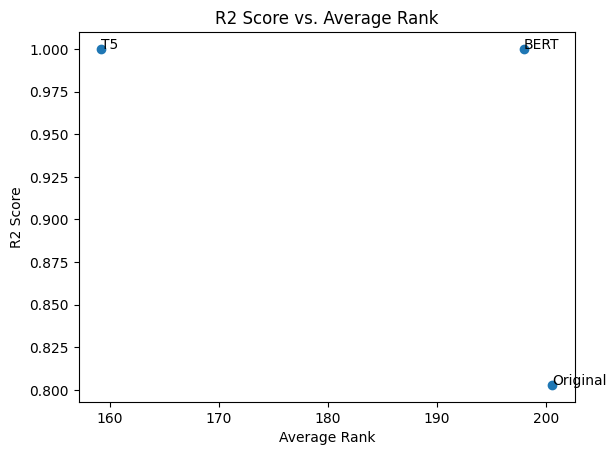

In [ ]:
# Scatter Plot of R2 Scores vs. Average Rank
average_ranks_original = np.mean(list(concept_ranks_ex2_original.values()))
average_ranks_t5 = np.mean(list(concept_ranks_ex2_t5.values()))
average_ranks_bert = np.mean(list(concept_ranks_ex2_BERT.values()))

x = [average_ranks_original, average_ranks_t5, average_ranks_bert]
y = [np.mean(r2_scores_ex2_original), np.mean(r2_scores_ex2_t5), np.mean(r2_scores_ex2_BERT)]
labels = ['Original', 'T5', 'BERT']

plt.scatter(x, y)
plt.xlabel('Average Rank')
plt.ylabel('R2 Score')
plt.title('R2 Score vs. Average Rank')
for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]))
plt.show()